In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import interpolate

In [15]:
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder {folder_path} created successfully.")
    else:
        print(f"Folder {folder_path} already exists.")


create_folder_if_not_exists("plots")
create_folder_if_not_exists("errors")

pi = np.double(np.pi)
interval_start = -2 * pi
interval_end = pi
base_domain = np.arange(interval_start, interval_end, 0.01)


def function_given(x):
    m = 2
    k = 2
    global pi
    return np.sin(m * x) * np.sin(k * (x * x) / pi)


def first_derivative(x):
    m = 2
    k = 2
    global pi
    return 2 * k * x * np.cos(k * x ** 2 / pi) * np.sin(m * x) / pi + m * np.sin(k * x ** 2 / pi) * np.cos(m * x)

Folder plots already exists.
Folder errors already exists.


**Równomierna dystrybucja**

In [16]:
def even_domain(x_min, x_max, number_of_points):
    return np.linspace(x_min, x_max, number_of_points, dtype=np.double)

**Zera wielomianu Czebyszewa**

In [17]:
def get_chebyshev_zeros(x_min=None, x_max=None, number_of_points=None):
    if x_min is None and x_max is not None or x_min is not None and x_max is None:
        raise ValueError("x_min and x_max must be both None or both not None")
    chebyshev_zeroes = np.array(0, dtype=np.double)
    for k in range(number_of_points):
        cur_zero = np.cos((2 * k + 1) * np.pi / (2 * number_of_points))
        if x_min is not None and x_max is not None:
            cur_zero = (x_max - x_min) / 2 * cur_zero + (x_max + x_min) / 2
        chebyshev_zeroes = np.append(chebyshev_zeroes, cur_zero)
    return chebyshev_zeroes[1:]

**Wizualizacja**

In [18]:
def visualise(domain=None, nodes_x=None, nodes_y=None, f_y=None, Pn_x=None, title=None, x_size=8, y_size=6,
              filename=None):
    '''
    :param domain: array of float64, of x coordinates of points to visualise
    :param nodes_x: array of x coordinates of nodes
    :param nodes_y: array of f(x) for each x in nodes_x
    :param f_y: array of f(x) for each x in domain
    :param Pn_x: array of Pn(x) for each x in domain
    :param title: a string
    :param x_size: size of a figure in x axis
    :param y_size: size of a figure in y axis
    :param filename: name of a file to save a figure
    :return: None
    '''
    plt.figure(figsize=(x_size, y_size))
    if nodes_x is not None and nodes_y is not None:
        plt.scatter(nodes_x, nodes_y, label="Węzły", color="green")
    if f_y is not None:
        plt.plot(domain, f_y, label="Zadana funckcja", color="blue")

    if title is not None:
        plt.plot(domain, Pn_x, label=title, color="red")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    if filename is not None:
        plt.savefig(f"plots/{filename}.png", dpi=300, format='png')
    plt.show()

**Implementacja funkcji do laboratorium**

In [19]:
function_given_values = []
for random_name in range(len(base_domain)):
    function_given_values.append(function_given(base_domain[random_name]))


def get_function_values(X):
    result = np.zeros(len(X), dtype=np.double)
    for i in range(len(X)):
        result[i] = function_given(X[i])
    return result


def get_abs_error(f1, f2):
    max_error = -1
    if len(f1) != len(f2):
        raise Exception("f1 and f2 must have the same length")
    for i in range(len(f1)):
        max_error = max(max_error, abs(f1[i] - f2[i]))
    return max_error


def get_square_mean_error(f1, f2):
    error_sum = 0
    if len(f1) != len(f2):
        raise Exception("f1 and f2 must have the same length")
    for i in range(len(f1)):
        error_sum += (f1[i] - f2[i]) ** 2
    return np.sqrt(error_sum) / len(f1)

**Spline za pomocą funkcji kwadratowej**

In [20]:
def get_value_of_square_interpolation(function, x_zeroes, x, mode, coefs):
    coef_idx = 0
    right_end = x_zeroes[1]
    while x > right_end:
        coef_idx += 1
        right_end = x_zeroes[coef_idx + 1]
    return coefs[0][coef_idx] + coefs[1][coef_idx] * (x - x_zeroes[coef_idx]) + coefs[2][coef_idx] * (
            x - x_zeroes[coef_idx]) ** 2


def square_spline(function, domain, x_zeroes, mode):
    def get_coefficients():
        nonlocal x_zeroes
        nonlocal function
        nonlocal mode
        n = len(x_zeroes)
        a = [function(x_zeroes[i]) for i in range(n - 1)]
        sigmas = [None]
        for i in range(1, n):
            sigma = (function(x_zeroes[i]) - function(x_zeroes[i - 1])) / (x_zeroes[i] - x_zeroes[i - 1])
            sigmas.append(sigma)
        b = None
        c = None
        if mode == 'natural':
            c = [0]
            b = [sigmas[1], sigmas[1]]
            for i in range(2, n):
                new_b = 2 * sigmas[i] - b[i - 1]
                b.append(new_b)
            for i in range(1,n - 1):
                c.append((b[i + 1] - b[i]) / (2 * (x_zeroes[i + 1] - x_zeroes[i])))

        elif mode == 'clamped':
            b = [0]
            for i in range(1, n):
                new_b = 2 * sigmas[i] - b[i - 1]
                b.append(new_b)
            c = []
            for i in range(n - 1):
                c.append((b[i + 1] - b[i]) / (2 * (x_zeroes[i + 1] - x_zeroes[i])))


        return [a, b, c]

    coefs = get_coefficients()
    result = []
    for j in range(len(domain)):
        result.append(get_value_of_square_interpolation(function, x_zeroes, domain[j], mode, coefs))
    return result


def visualise_square(number_of_nodes, domain, function, mode, filename=None):
    nodes_x = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
    nodes_y = []
    for i in range(len(nodes_x)):
        nodes_y.append(function(nodes_x[i]))
    own_spline_natural = square_spline(function=function,
                                       domain=domain,
                                       x_zeroes=nodes_x,
                                       mode=mode)
    visualise(domain=base_domain, nodes_x=nodes_x, nodes_y=nodes_y, f_y=function_given_values, Pn_x=own_spline_natural,
              title=f"square spline with {mode} boundary", filename=filename)

**Spline za pomocą funkcji sześciennej**

In [21]:
def cubic_spline(function, domain, x_zeroes, mode):
    def y(x):
        return function(x)

    def h(i):
        return x_zeroes[i + 1] - x_zeroes[i]

    def solve():
        nonlocal x_zeroes
        nonlocal function
        nonlocal mode
        nonlocal y
        nonlocal h
        n = len(x_zeroes)

        def delta(i):
            return (y(x_zeroes[i + 1]) - y(x_zeroes[i])) / h(i)

        def second_delta(i):
            return (delta(i + 1) - delta(i)) / x_zeroes[i + 2] - x_zeroes[i]

        def third_delta(i):
            return (second_delta(i + 1) - second_delta(i)) / x_zeroes[i + 3] - x_zeroes[i]

        A = np.zeros(shape=(n, n))
        B = np.zeros(shape=(n, 1))
        for i in range(1, n - 1):
            A[i][i - 1] = h(i - 1)
            A[i][i] = 2 * (h(i - 1) + h(i))
            A[i][i + 1] = h(i)
            B[i] = delta(i) - delta(i - 1)

        sigmas = None
        if mode == 'cubic':
            A[0][0] = -h(0)
            A[0][1] = h(0)
            A[n - 1][n - 2] = h(n - 2)
            A[n - 1][n - 1] = -h(n - 2)

            B[0] = np.power(h(0), 2) * third_delta(0)
            B[n - 1] = -np.power(h(n - 2), 2) * third_delta(n - 4)
            sigmas = np.linalg.solve(A, B)
        elif mode == 'free':
            A = A[1:-1, 1:-1]
            B = B[1:-1]
            sigmas = [0, *np.linalg.solve(A, B), 0]
        else:
            raise Exception("Unknown mode")
        return sigmas

    sigmas = solve()
    if sigmas is None:
        raise Exception("Sigmas is None")
    result = []
    for j in domain:
        i = 0
        right_end = x_zeroes[1]
        while j > right_end:
            i += 1
            right_end = x_zeroes[i + 1]

        a = function(x_zeroes[i])
        b = (y(x_zeroes[i + 1]) - y(x_zeroes[i])) / h(i) - h(i) * (sigmas[i + 1] + 2 * sigmas[i])
        c = 3 * sigmas[i]
        d = (sigmas[i + 1] - sigmas[i]) / h(i)
        result.append(a + b * (j - x_zeroes[i]) + c * np.power(j - x_zeroes[i], 2) + d * np.power(j - x_zeroes[i], 3))
    #flatten result array
    result = [item for sublist in result for item in sublist]
    return result


def visualise_cubic(number_of_nodes, domain, function, mode, filename=None):
    nodes_x = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
    nodes_y = []
    for i in range(len(nodes_x)):
        nodes_y.append(function(nodes_x[i]))
    own_spline_natural = cubic_spline(function=function,
                                      domain=domain,
                                      x_zeroes=nodes_x,
                                      mode=mode)
    visualise(domain=base_domain, nodes_x=nodes_x, nodes_y=nodes_y, f_y=function_given_values, Pn_x=own_spline_natural,
              title=f"cubic spline with {mode} boundary", filename=filename)

**Wykonanie ćwiczenia**

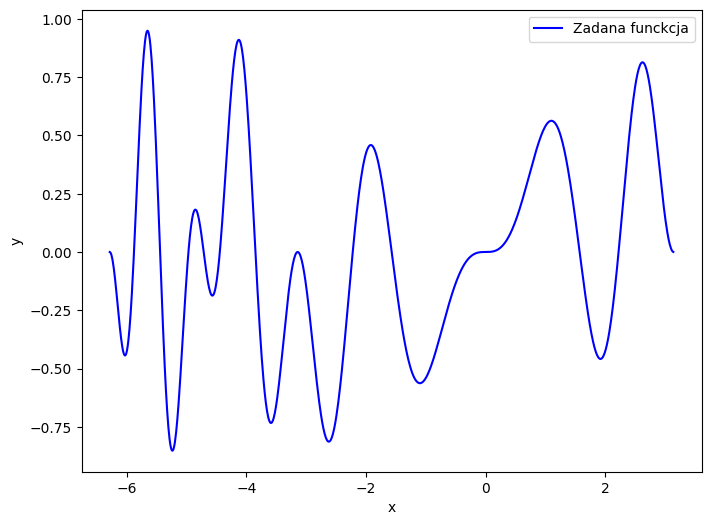

In [22]:
visualise(base_domain, None, None, function_given_values)

Liczba węzłów:  5
Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


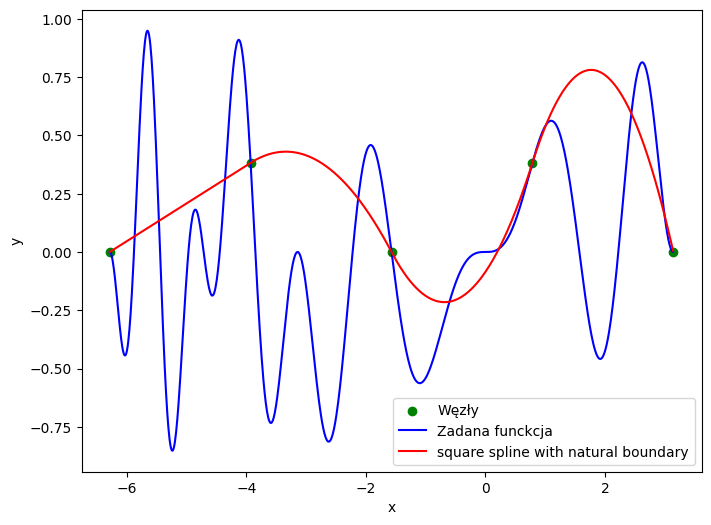

Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


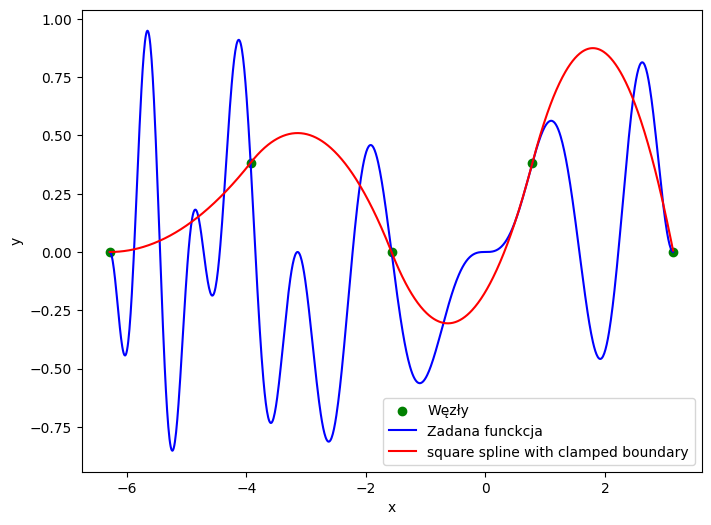

Liczba węzłów:  5
Wizualizacja funkcji sześciennych granica sześcienna, węzły równoodległe


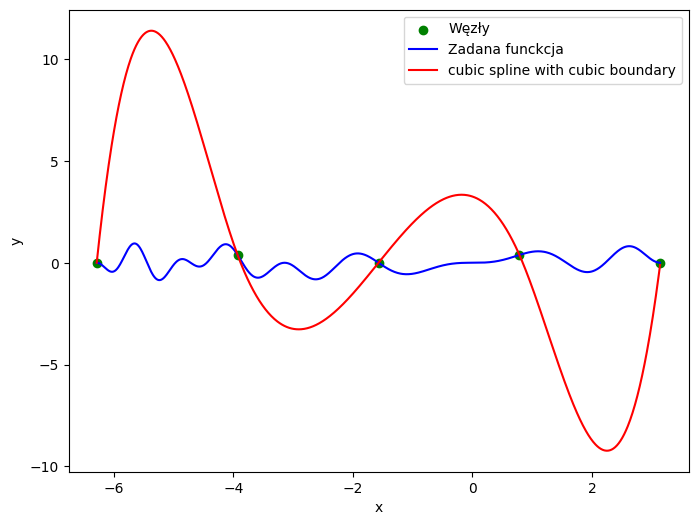

Wizualizacja funkcji sześciennych granica naturalna, węzły równoodległe


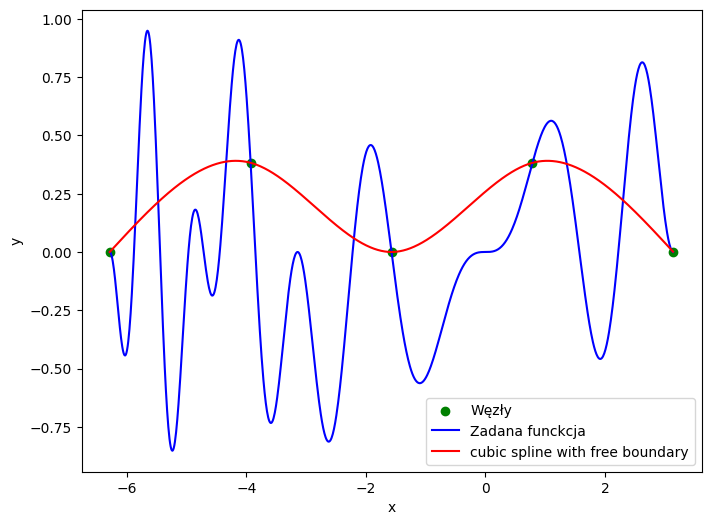

Liczba węzłów:  7
Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


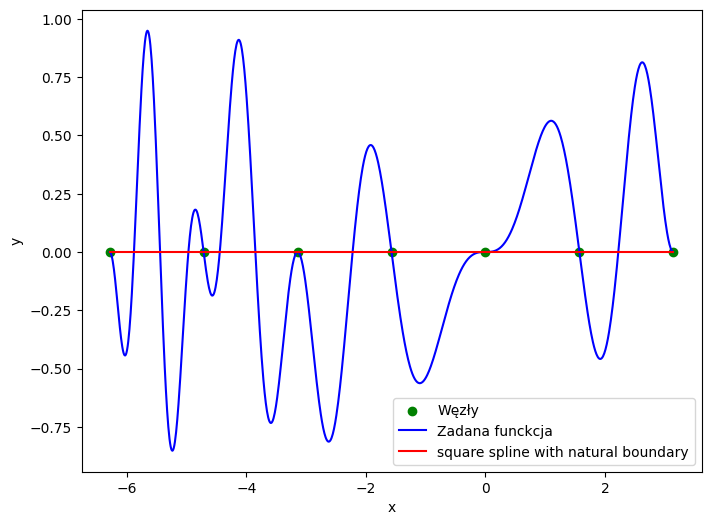

Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


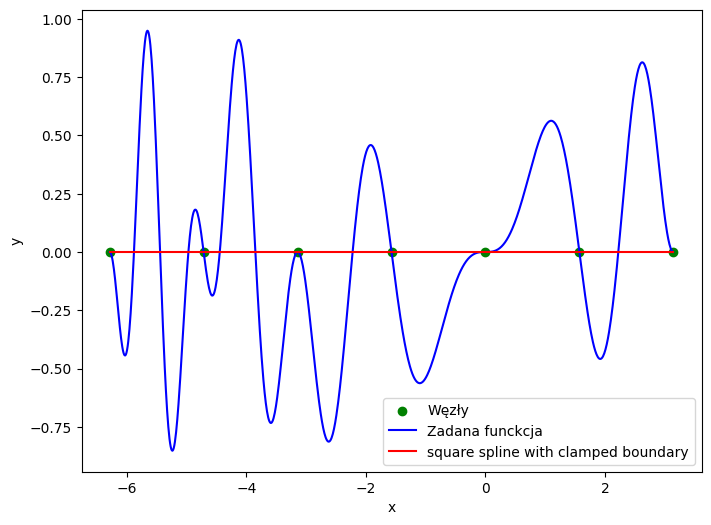

Liczba węzłów:  7
Wizualizacja funkcji sześciennych granica sześcienna, węzły równoodległe


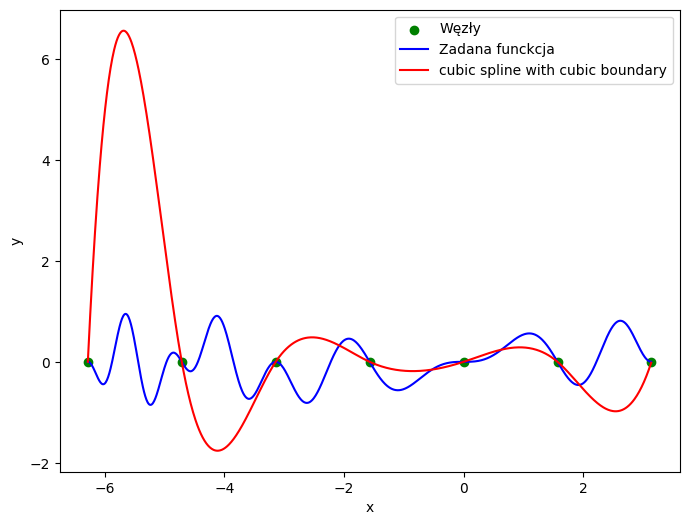

Wizualizacja funkcji sześciennych granica naturalna, węzły równoodległe


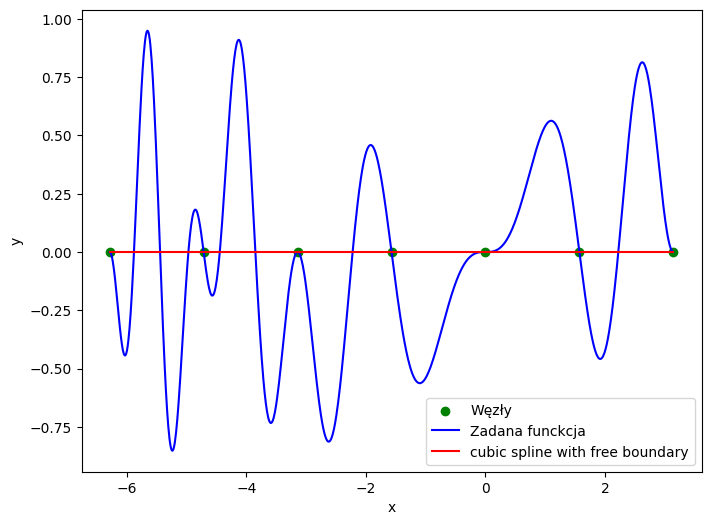

Liczba węzłów:  10
Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


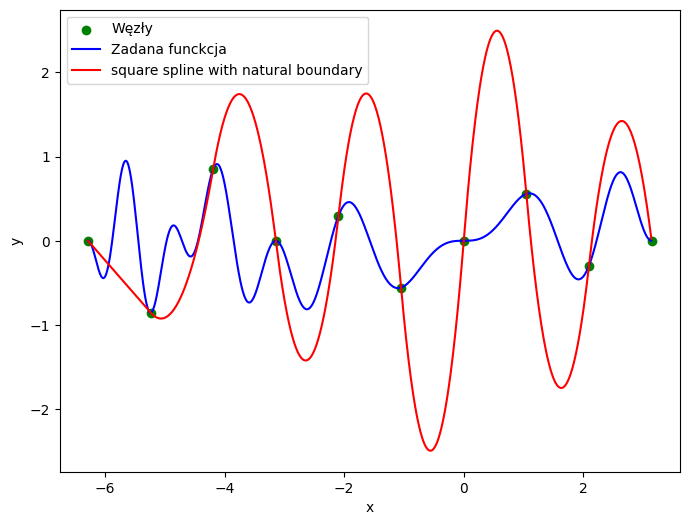

Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


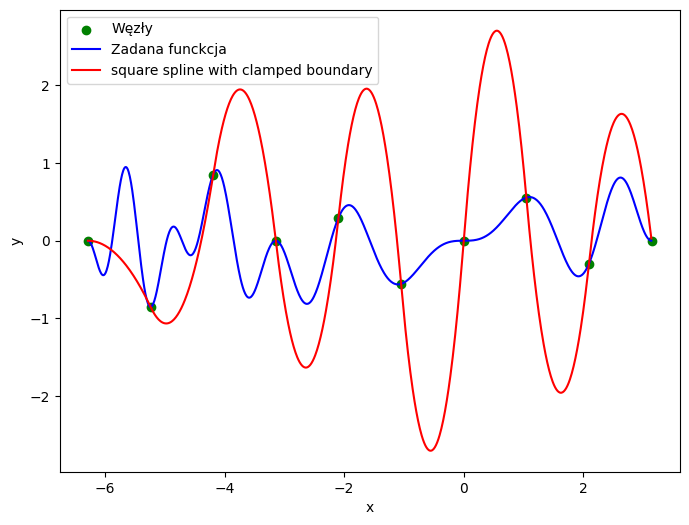

Liczba węzłów:  10
Wizualizacja funkcji sześciennych granica sześcienna, węzły równoodległe


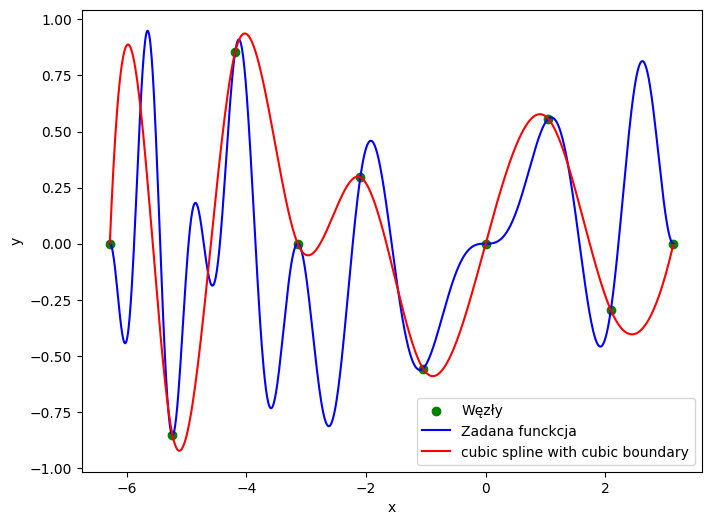

Wizualizacja funkcji sześciennych granica naturalna, węzły równoodległe


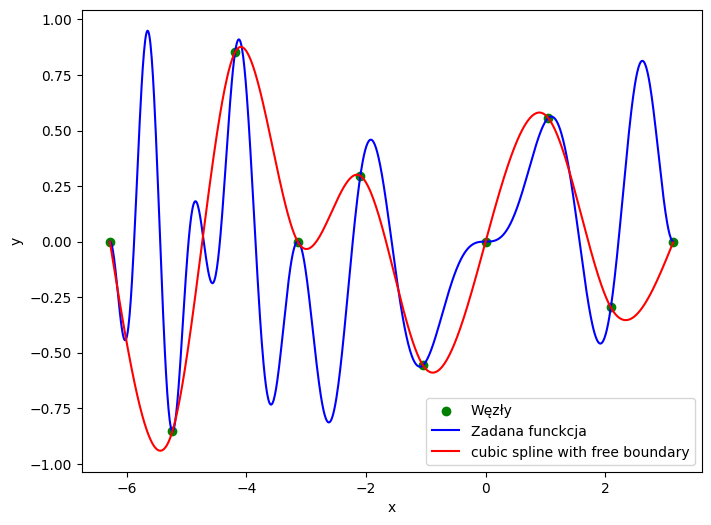

Liczba węzłów:  15
Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


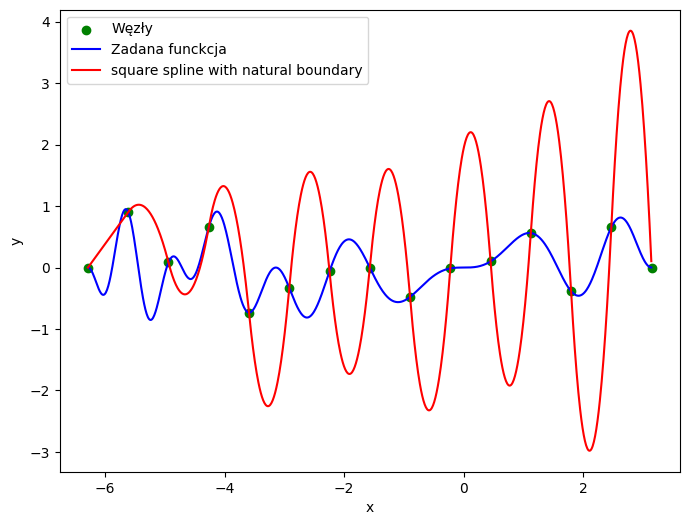

Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


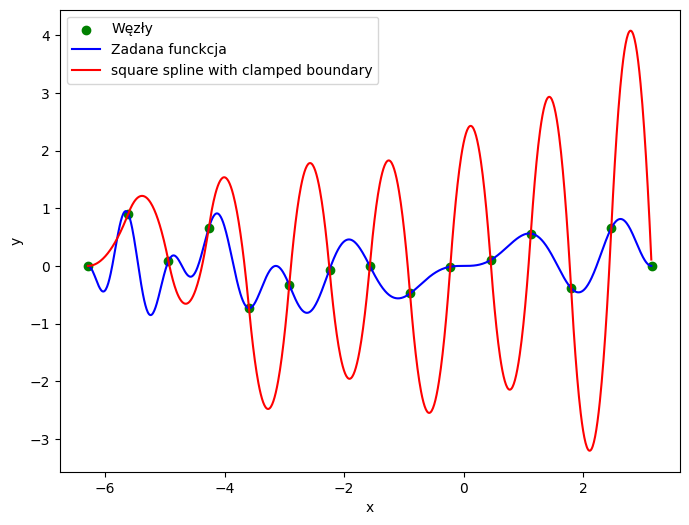

Liczba węzłów:  15
Wizualizacja funkcji sześciennych granica sześcienna, węzły równoodległe


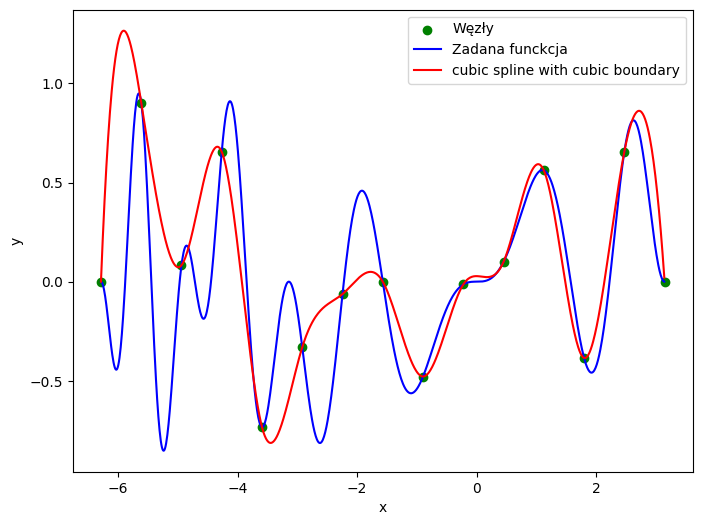

Wizualizacja funkcji sześciennych granica naturalna, węzły równoodległe


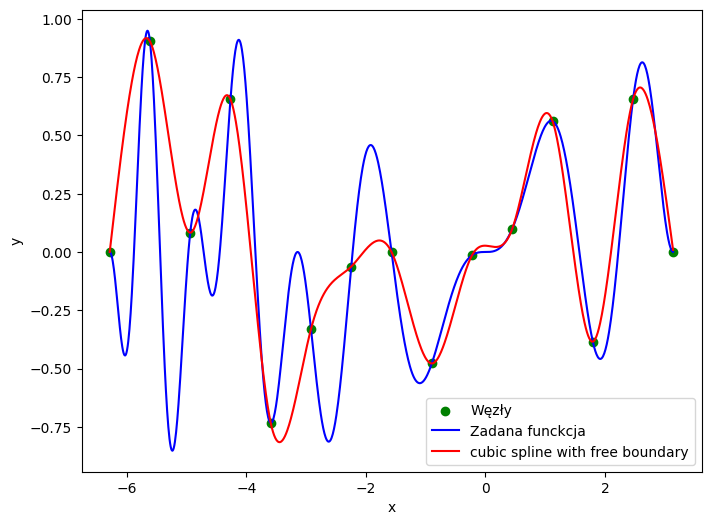

Liczba węzłów:  20
Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


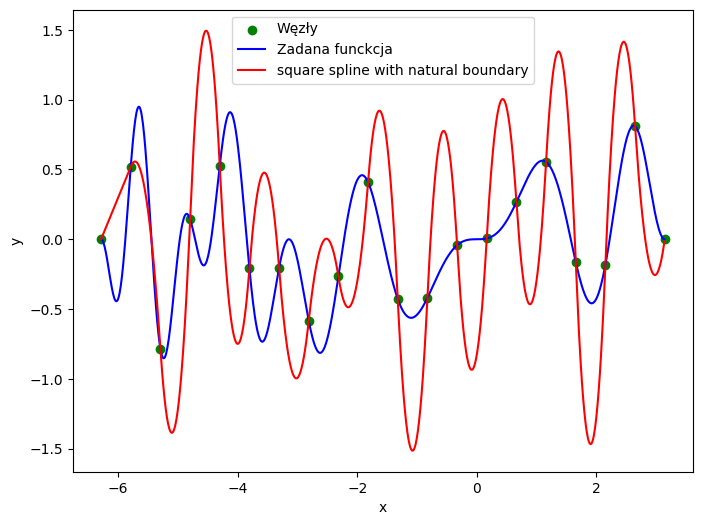

Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


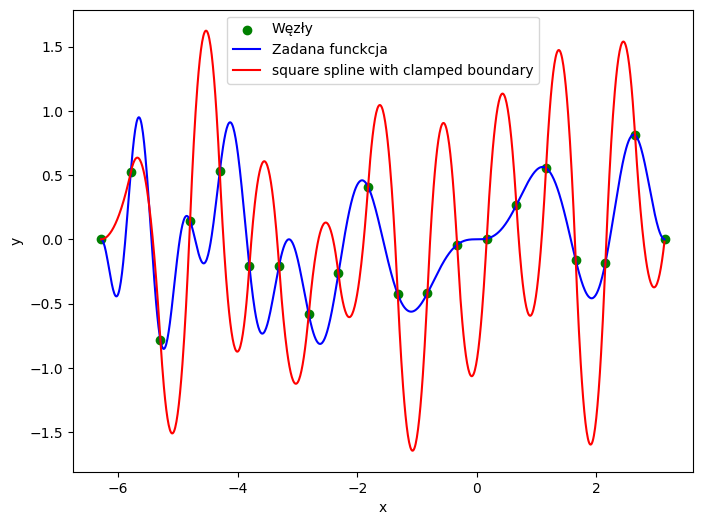

Liczba węzłów:  20
Wizualizacja funkcji sześciennych granica sześcienna, węzły równoodległe


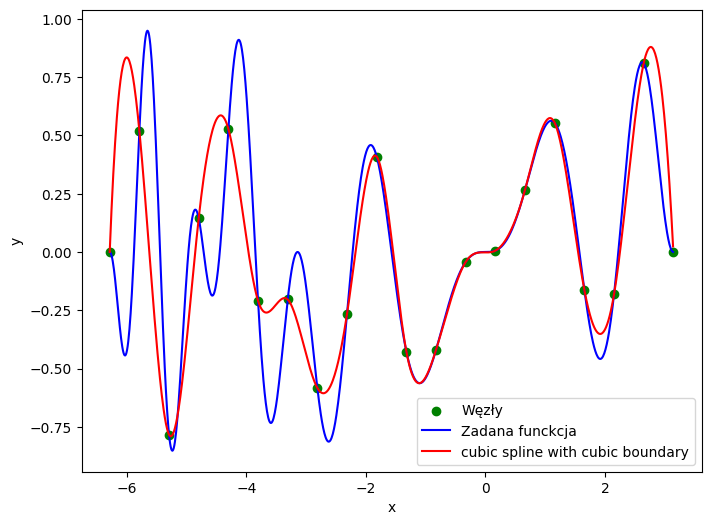

Wizualizacja funkcji sześciennych granica naturalna, węzły równoodległe


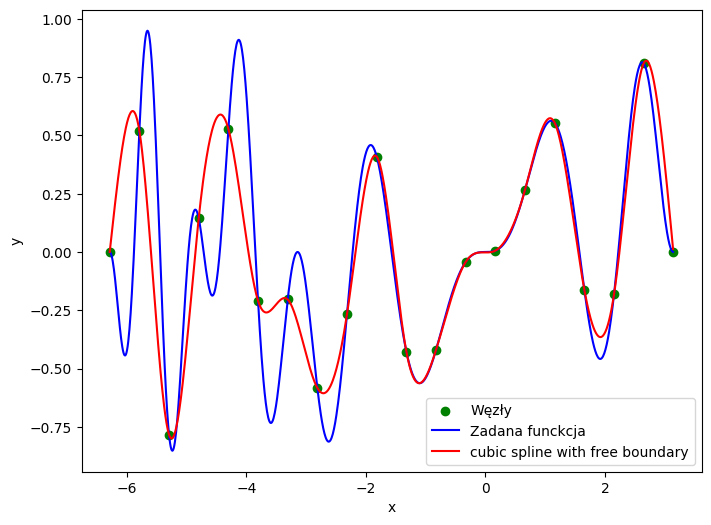

Liczba węzłów:  25
Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


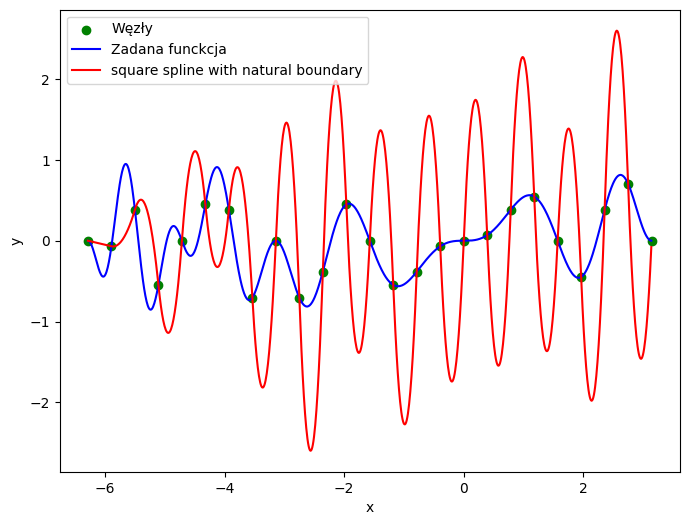

Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


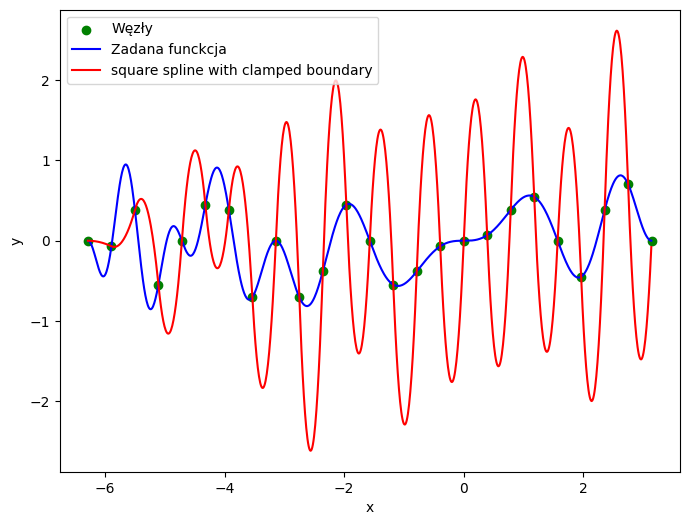

Liczba węzłów:  25
Wizualizacja funkcji sześciennych granica sześcienna, węzły równoodległe


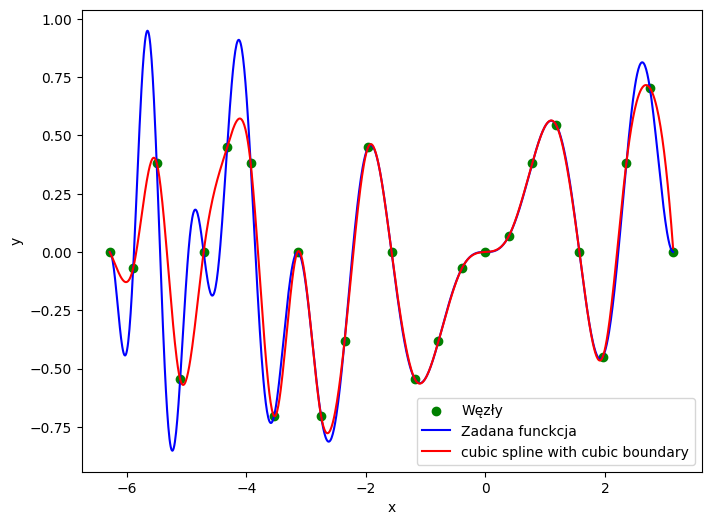

Wizualizacja funkcji sześciennych granica naturalna, węzły równoodległe


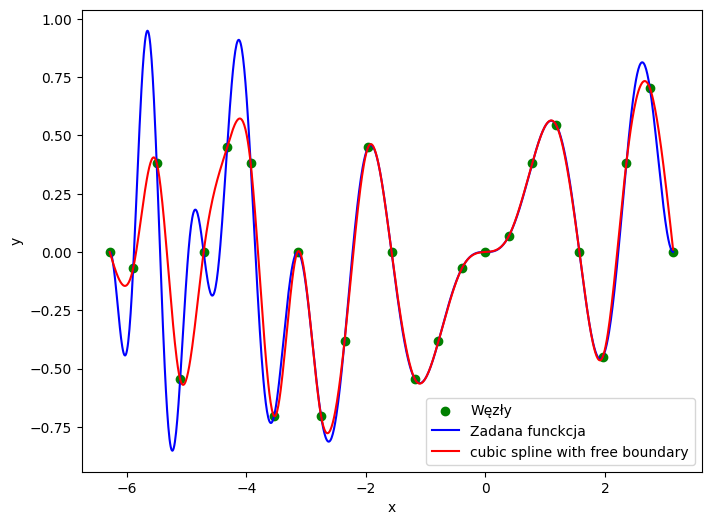

Liczba węzłów:  30
Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


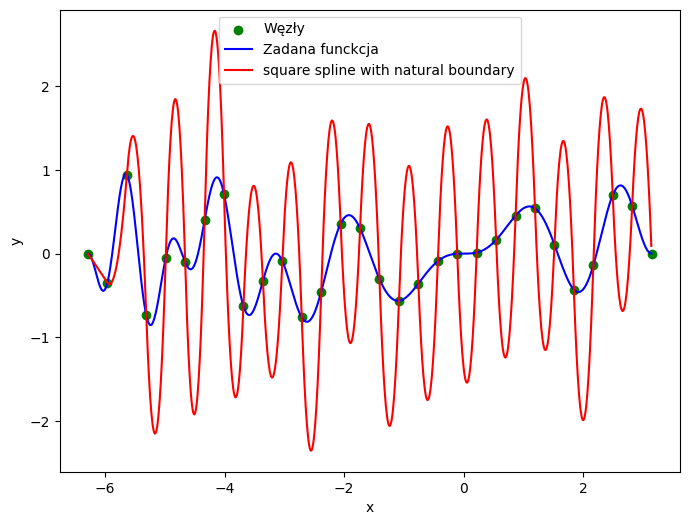

Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


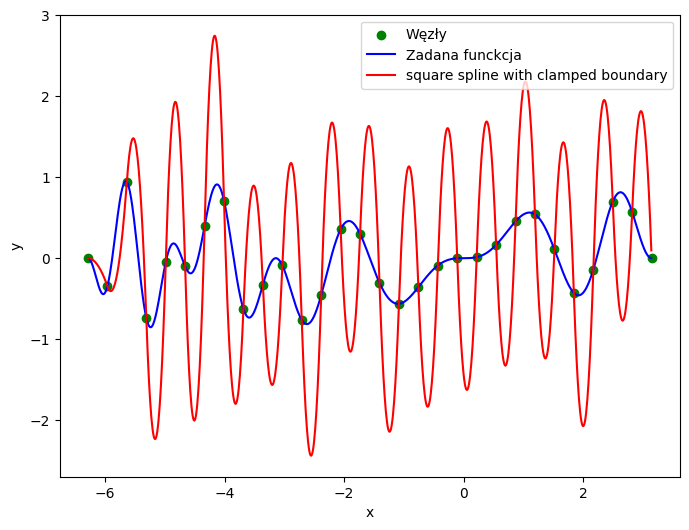

Liczba węzłów:  30
Wizualizacja funkcji sześciennych granica sześcienna, węzły równoodległe


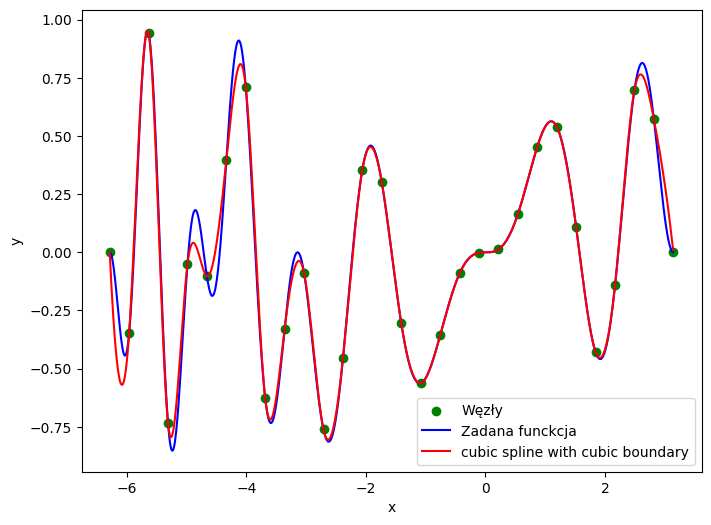

Wizualizacja funkcji sześciennych granica naturalna, węzły równoodległe


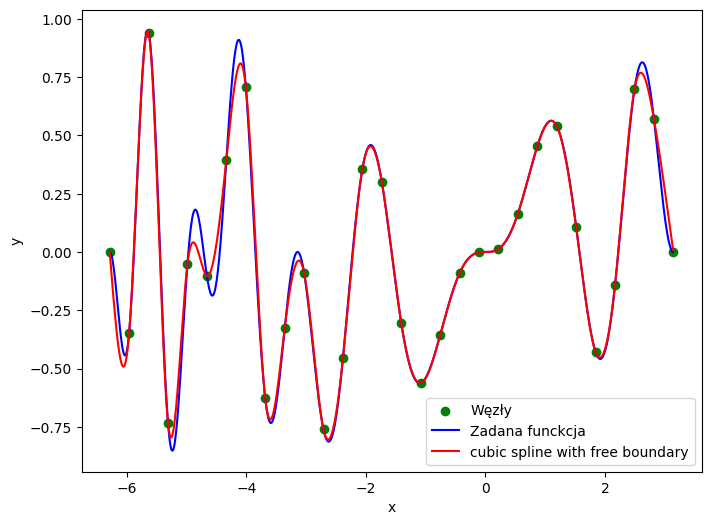

Liczba węzłów:  35
Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


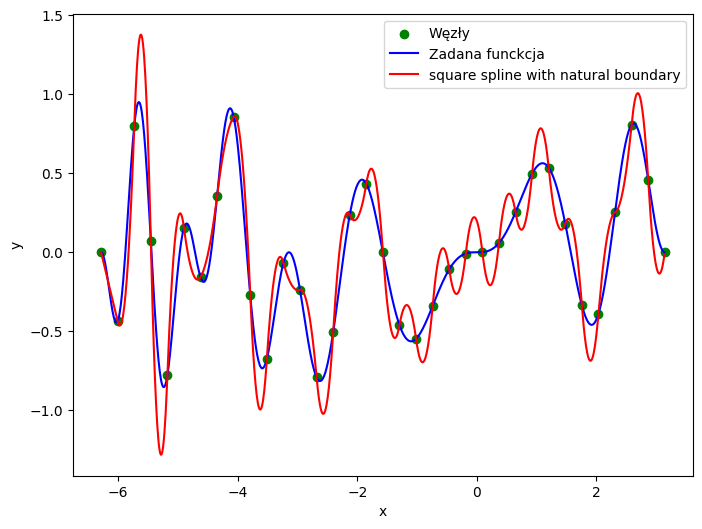

Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


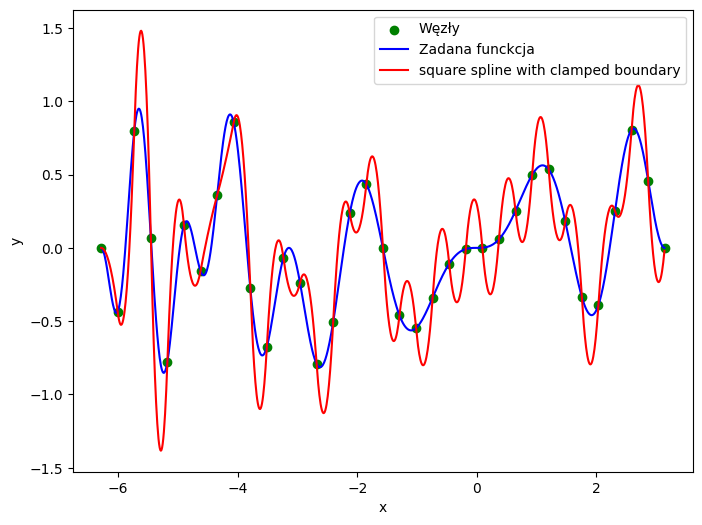

Liczba węzłów:  35
Wizualizacja funkcji sześciennych granica sześcienna, węzły równoodległe


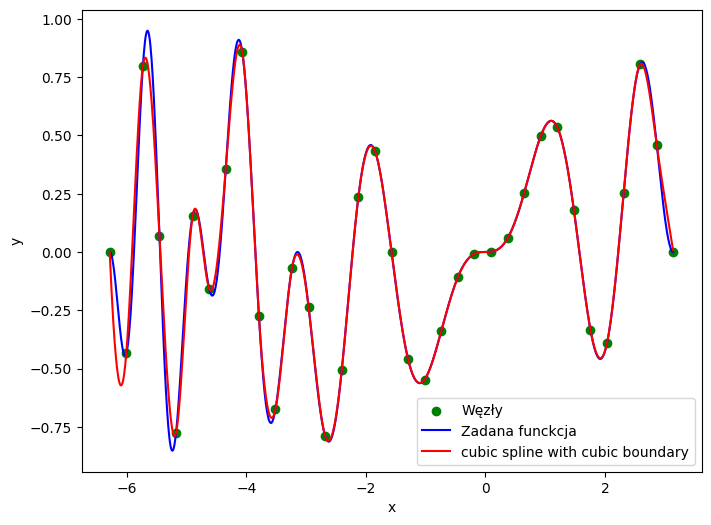

Wizualizacja funkcji sześciennych granica naturalna, węzły równoodległe


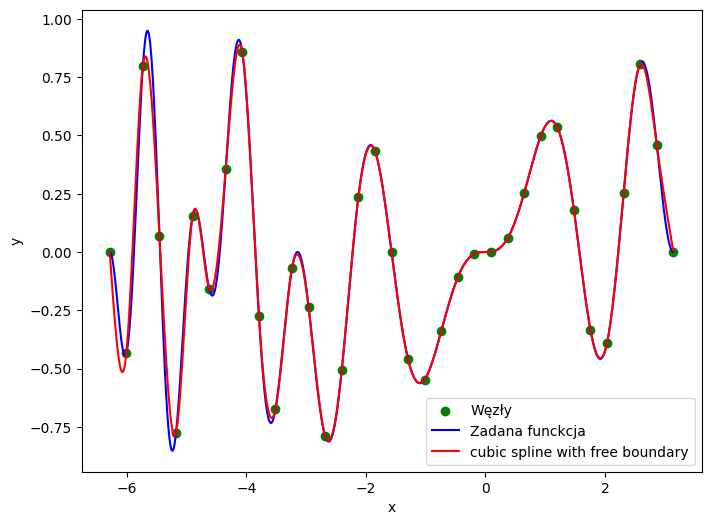

Liczba węzłów:  50
Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


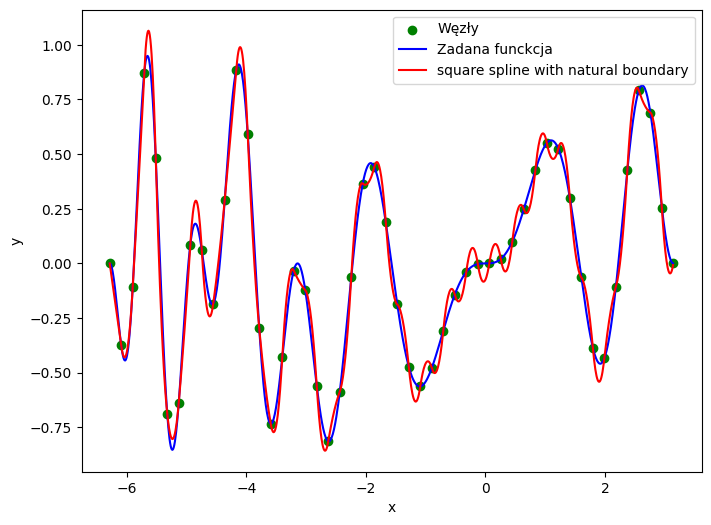

Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


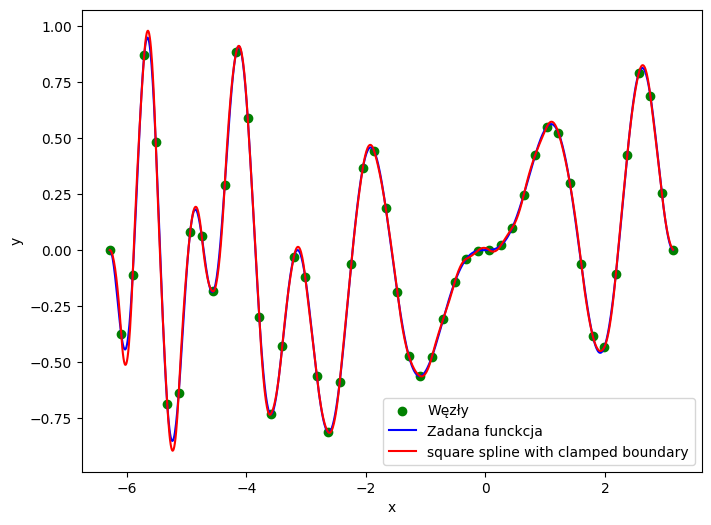

Liczba węzłów:  50
Wizualizacja funkcji sześciennych granica sześcienna, węzły równoodległe


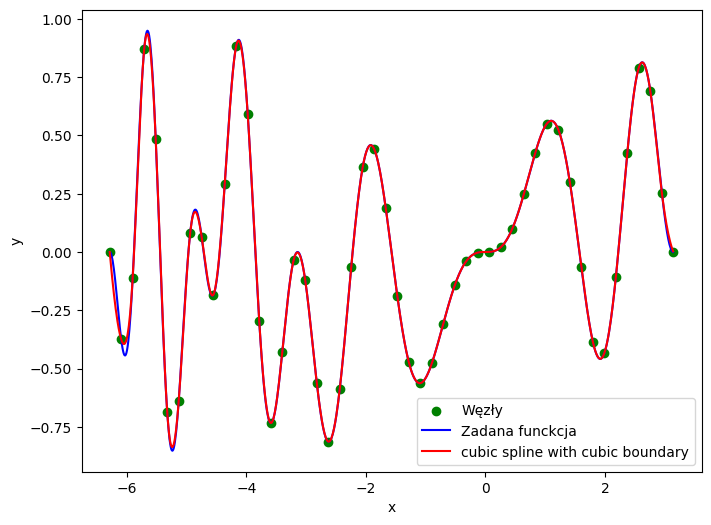

Wizualizacja funkcji sześciennych granica naturalna, węzły równoodległe


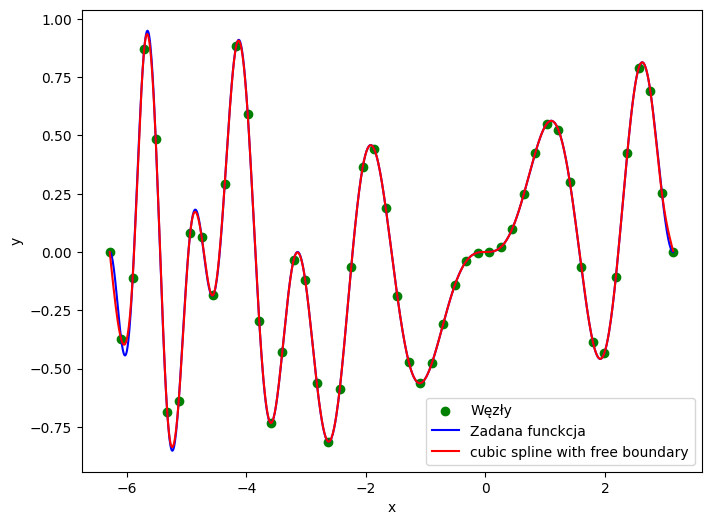

Liczba węzłów:  70
Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


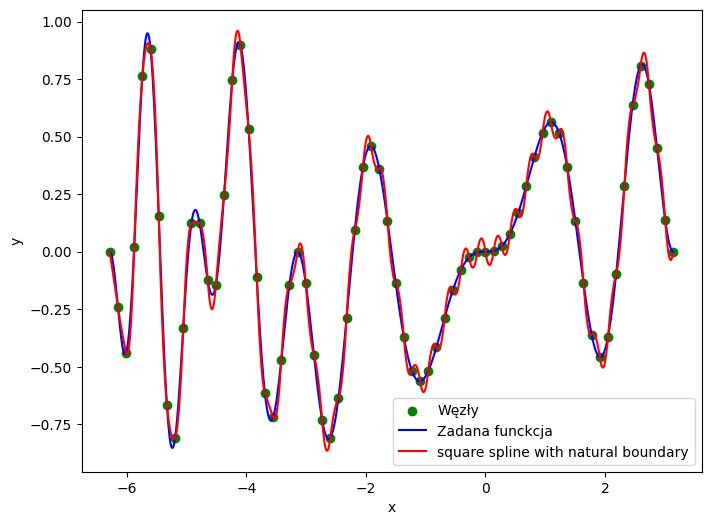

Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


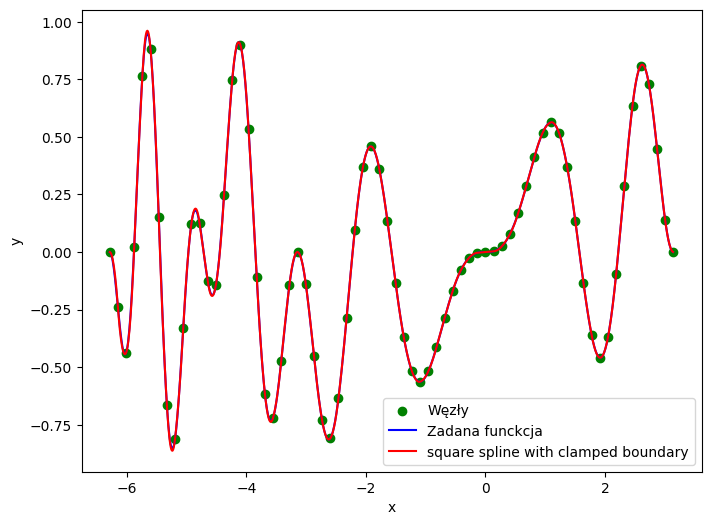

Liczba węzłów:  70
Wizualizacja funkcji sześciennych granica sześcienna, węzły równoodległe


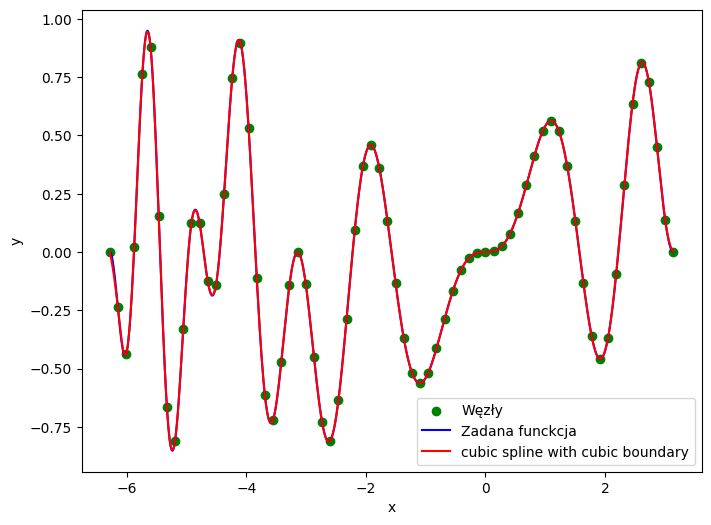

Wizualizacja funkcji sześciennych granica naturalna, węzły równoodległe


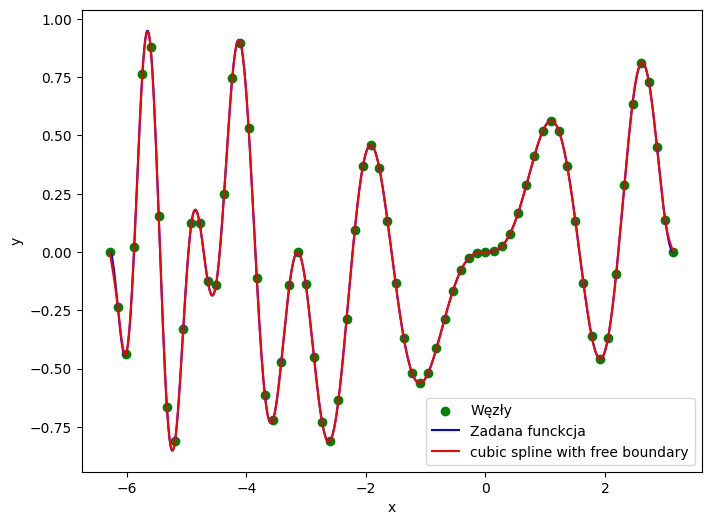

Liczba węzłów:  80
Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


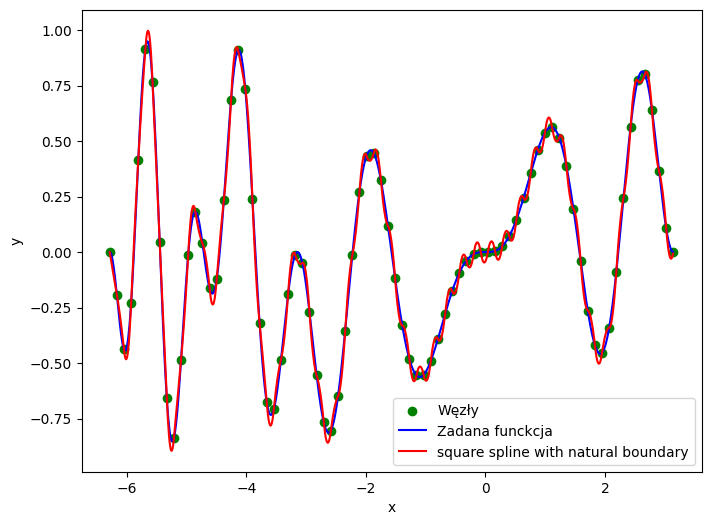

Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe


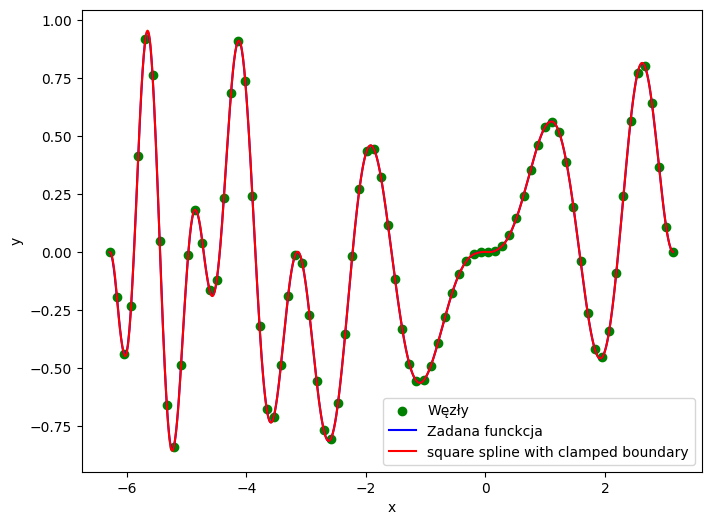

Liczba węzłów:  80
Wizualizacja funkcji sześciennych granica sześcienna, węzły równoodległe


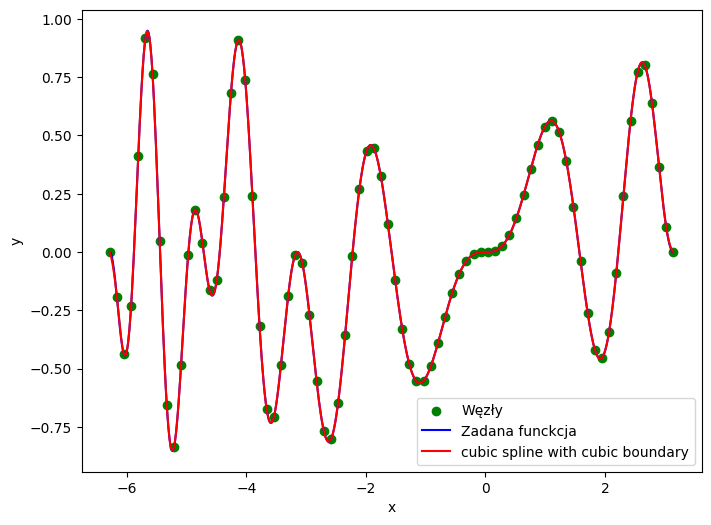

Wizualizacja funkcji sześciennych granica naturalna, węzły równoodległe


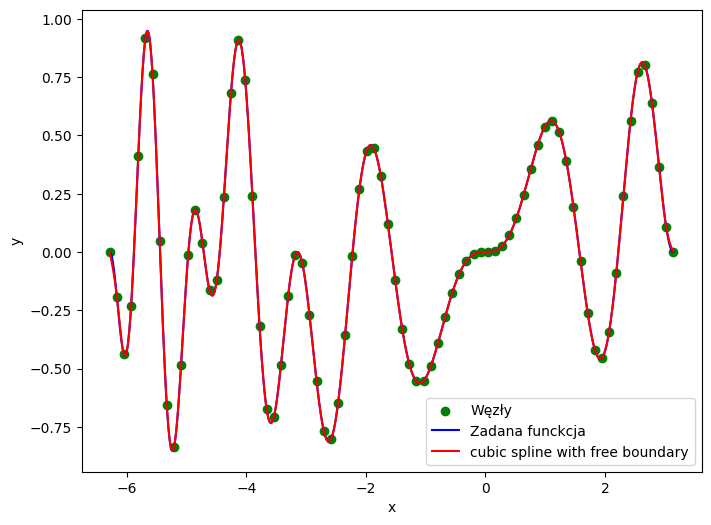

In [23]:
given_number_of_nodes = [5, 7, 10, 15, 20, 25, 30, 35, 50, 70, 80]


def get_all_visualisations(number):
    print("Liczba węzłów: ", number)
    even_nodes = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number)
    chebyshev_nodes = get_chebyshev_zeros(x_min=interval_start, x_max=interval_end, number_of_points=number)
    print("Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe")
    visualise_square(number_of_nodes=number,
                     domain=base_domain,
                     function=function_given,
                     mode="natural",
                     filename=f"square_{number}_natural")
    print("Wizualizacja funkcji kwadratowych granica naturalna, węzły równoodległe")
    visualise_square(number_of_nodes=number,
                     domain=base_domain,
                     function=function_given,
                     mode="clamped",
                     filename=f"square_{number}_clamped")
    print("Liczba węzłów: ", number)
    even_nodes = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number)
    print("Wizualizacja funkcji sześciennych granica sześcienna, węzły równoodległe")
    visualise_cubic(number_of_nodes=number,
                    domain=base_domain,
                    function=function_given,
                    mode="cubic",
                    filename=f"cubic_{number}_cubic")
    print("Wizualizacja funkcji sześciennych granica naturalna, węzły równoodległe")
    visualise_cubic(number_of_nodes=number,
                    domain=base_domain,
                    function=function_given,
                    mode="free",
                    filename=f"cubic_{number}_natural")


for cur_number in given_number_of_nodes:
    get_all_visualisations(cur_number)

In [24]:
import csv


def save_to_csv(filename, data):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

In [25]:
def square_results_errors():
    global given_number_of_nodes
    csv_header = ["Liczba węzłów", "Natural bład maksymalny", "Natural bład kwadratowy",
                  "Clamped bład kwadratowy", "Clamped bład kwadratowy"]
    csv_file = [csv_header]
    for number_of_nodes in given_number_of_nodes:
        csv_record = [number_of_nodes]
        even_nodes = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
        exact_result = []
        for i in range(len(base_domain)):
            exact_result.append(function_given(base_domain[i]))

        square_natural_result = square_spline(function=function_given,
                                              domain=base_domain,
                                              x_zeroes=even_nodes,
                                              mode="natural")
        square_natural_abs_error = get_abs_error(exact_result, square_natural_result)
        csv_record.append(square_natural_abs_error)
        square_natural_even_sqrt_error = get_square_mean_error(exact_result, square_natural_result)
        csv_record.append(square_natural_even_sqrt_error)

        square_clamped_result = square_spline(function=function_given,
                                              domain=base_domain,
                                              x_zeroes=even_nodes,
                                              mode="clamped")
        square_clamped_abs_error = get_abs_error(exact_result, square_clamped_result)
        csv_record.append(square_clamped_abs_error)
        square_clamped_sqrt_error = get_square_mean_error(exact_result, square_clamped_result)
        csv_record.append(square_clamped_sqrt_error)
        csv_file.append(csv_record)

    save_to_csv("errors/square_errors.csv", csv_file)


square_results_errors()

In [26]:
def cubic_results_errors():
    global given_number_of_nodes
    csv_header = ["Liczba węzłów", "Natural bład maksymalny", "Natural bład kwadratowy",
                  "Cubic bład kwadratowy", "Cubic bład kwadratowy"]
    csv_file = [csv_header]
    for number_of_nodes in given_number_of_nodes:
        csv_record = [number_of_nodes]
        even_nodes = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
        exact_result = []
        for i in range(len(base_domain)):
            exact_result.append(function_given(base_domain[i]))

        cubic_natural_result = cubic_spline(function=function_given,
                                              domain=base_domain,
                                              x_zeroes=even_nodes,
                                              mode="free")
        cubic_natural_abs_error = get_abs_error(exact_result, cubic_natural_result)
        csv_record.append(cubic_natural_abs_error)
        cubic_natural_even_sqrt_error = get_square_mean_error(exact_result, cubic_natural_result)
        csv_record.append(cubic_natural_even_sqrt_error)

        cubic_clamped_result = cubic_spline(function=function_given,
                                              domain=base_domain,
                                              x_zeroes=even_nodes,
                                              mode="cubic")
        cubic_clamped_abs_error = get_abs_error(exact_result, cubic_clamped_result)
        csv_record.append(cubic_clamped_abs_error)
        cubic_clamped_sqrt_error = get_square_mean_error(exact_result, cubic_clamped_result)
        csv_record.append(cubic_clamped_sqrt_error)
        csv_file.append(csv_record)

    save_to_csv("errors/cubic_errors.csv", csv_file)


cubic_results_errors()